##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [32]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image segmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial focuses on the task of image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

In [33]:
import tensorflow as tf

import tensorflow_datasets as tfds

import numpy as np
import pickle
from PIL import Image
import PIL
import gzip

In [34]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random

## Download the Oxford-IIIT Pets dataset

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

In [35]:
from sklearn.model_selection import train_test_split

dataset_train = []

with (open("/content/drive/My Drive/task3/dataset_train.pkl", "rb")) as openfile:
    dataset_train = pickle.load(openfile)

print(len(dataset_train))


195


In [36]:
def normalize(image):
  image = image.astype(float) / 255.0
  return image

In [37]:
def load_image(datapoint):

  input_image = Image.fromarray(datapoint)
  input_image = input_image.resize((128, 128))


  input_image = np.array(input_image)#np.array(input_image.convert('RGB'))
  input_image = normalize(input_image)


  return input_image

def load_mask(datapoint):
  input_mask = Image.fromarray(datapoint)

  input_mask = np.array(input_mask.resize((128, 128), resample=PIL.Image.Resampling.NEAREST))
  input_mask = input_mask[:,:,0]

  input_mask = np.array(np.reshape(input_mask, input_mask.shape + (1,)))
  input_mask = normalize(input_mask)

  return input_mask

In [38]:
images = [load_image(datapoint['image']) for datapoint in dataset_train]
masks = [load_mask(datapoint['label']) for datapoint in dataset_train]

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size = 0.20, random_state = 42)

 In addition, the image color values are normalized to the `[0, 1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [39]:
def load_image_old(datapoint):

  input_image = datapoint['image']
  input_mask = datapoint['label']
  #input_image = np.reshape(input_image, input_image.shape + (1,))

  input_image = Image.fromarray(input_image)

  input_mask = Image.fromarray(input_mask)


  input_image = input_image.resize((128, 128))
  input_mask = np.array(input_mask.resize((128, 128), resample=PIL.Image.Resampling.NEAREST))

  """
  input_image = tf.image.resize(input_image, (128, 128))
  input_mask = tf.image.resize(
    datapoint['label'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )
  """
  input_mask = input_mask[:,:,0]



  input_mask = np.array(np.reshape(input_mask, input_mask.shape + (1,)))

  input_image = np.array(input_image.convert('RGB'))

  input_image, input_mask = normalize(input_image, input_mask)


  return input_image, input_mask

def load_image_old(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  print(type(datapoint['segmentation_mask']))
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits:

In [40]:
TRAIN_LENGTH = len(dataset_train)#info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [41]:
#train_images_old = dataset_old['train'].map(load_image_old, num_parallel_calls=tf.data.AUTOTUNE)
#print(type(dataset_old['train']))

#train_data = [load_image(sample) for sample in dataset_train]
#test_images_old = dataset_old['test'].map(load_image_old, num_parallel_calls=tf.data.AUTOTUNE)
#test_data = [load_image(sample) for sample in dataset_test]

The following class performs a simple augmentation by randomly-flipping an image.
Go to the [Image augmentation](data_augmentation.ipynb) tutorial to learn more.


In [42]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

Visualize an image example and its corresponding mask from the dataset:

In [43]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i], cmap='gray')
    plt.axis('off')
  plt.show()

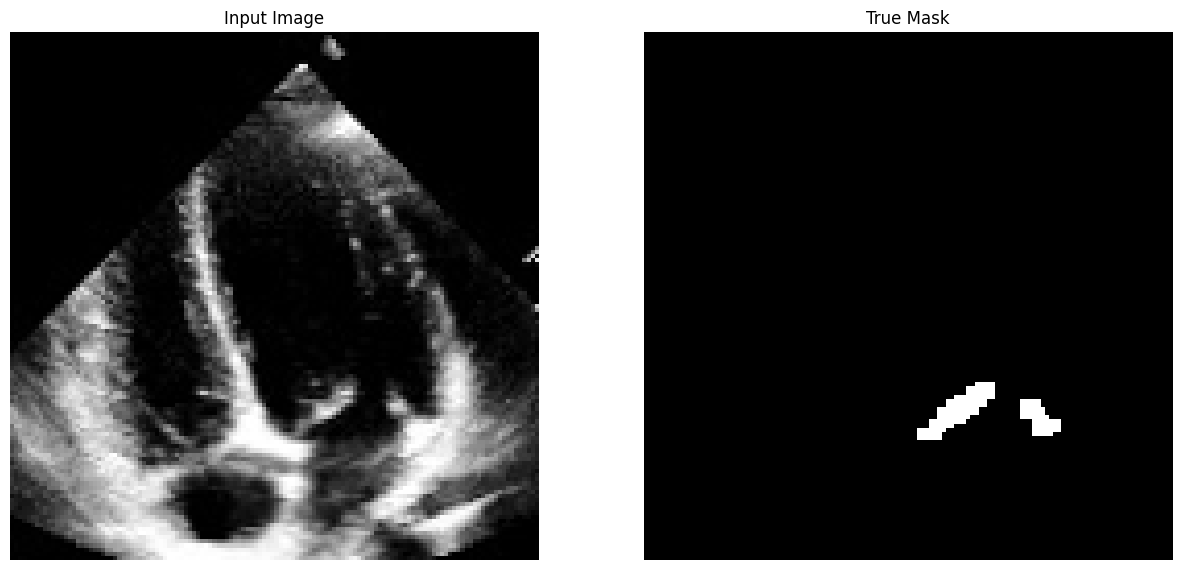

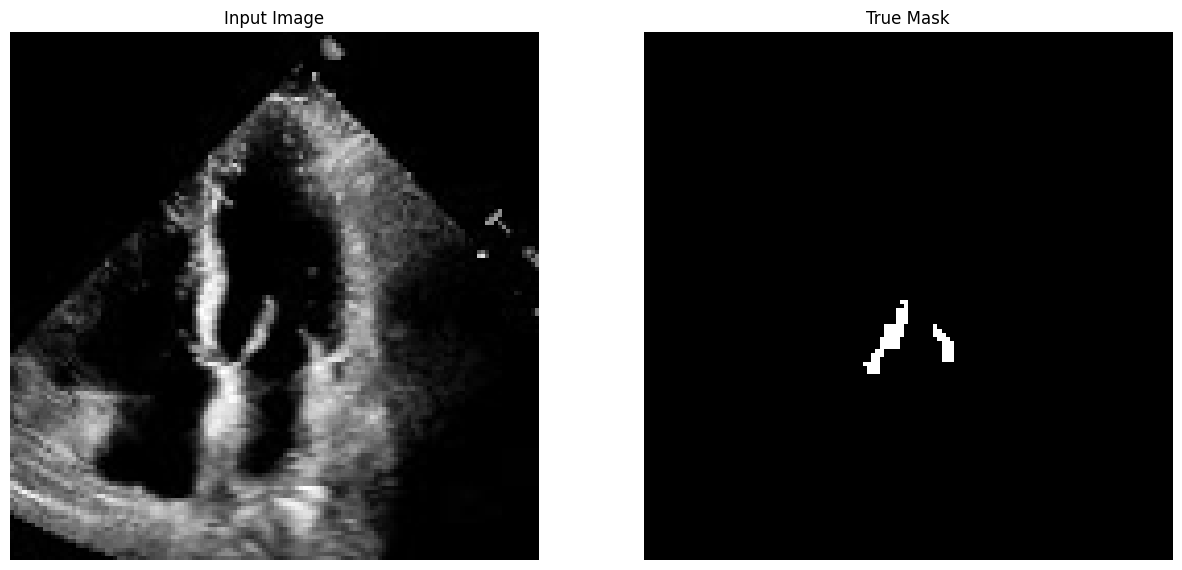

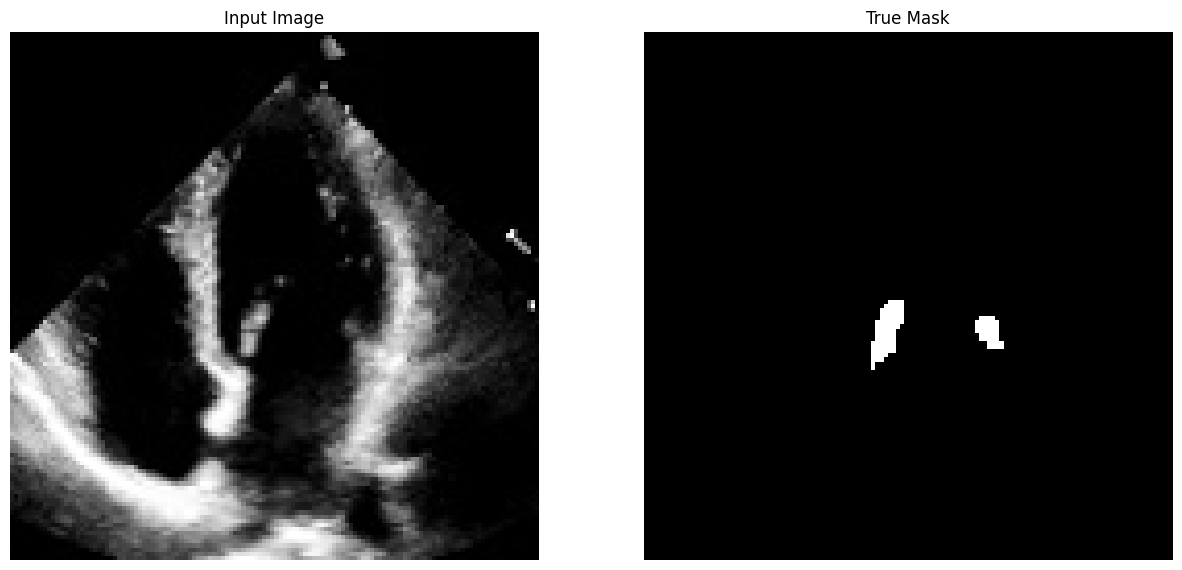

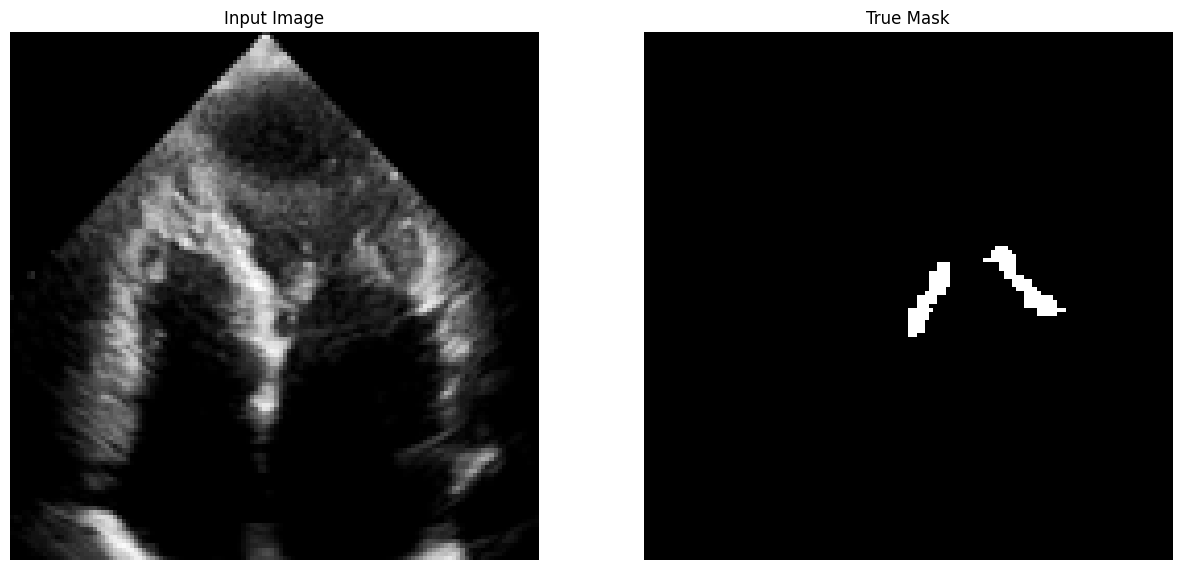

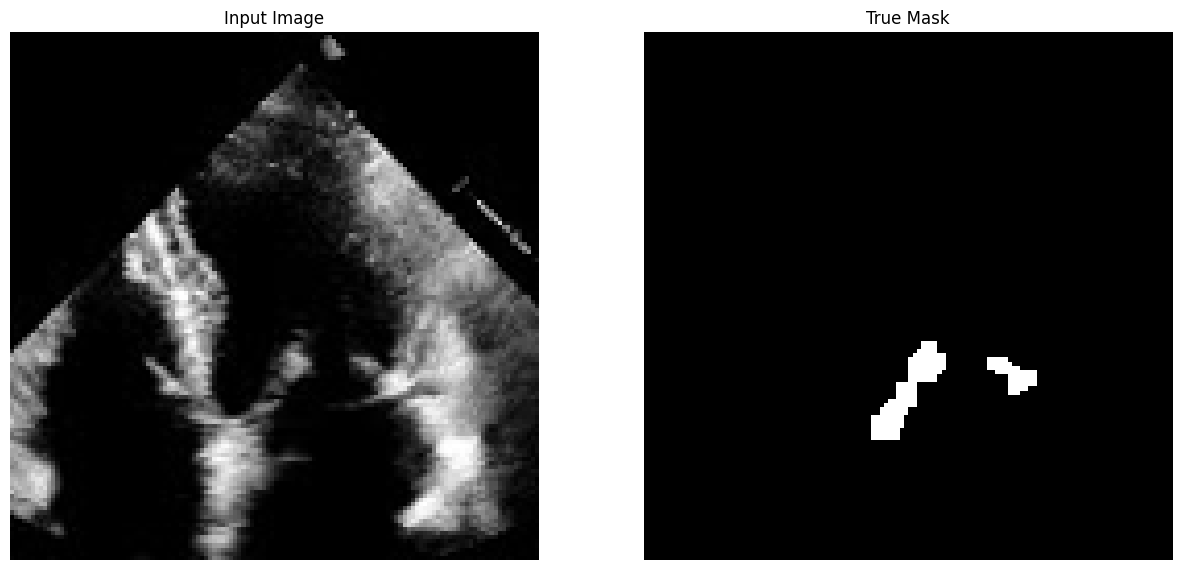

In [44]:
for i in range(5):
  image = images_train[i]
  mask = masks_train[i]
  sample_image, sample_mask = image, mask
  display([image, mask])

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)


As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [45]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

input_shape = (128, 128, 1)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model.

Since this is a multiclass classification problem, use the `tf.keras.losses.SparseCategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [46]:
import keras
#from keras.saving import register_keras_serializable

OUTPUT_CLASSES = 2


# Convert the class weights to a TensorFlow tensor
class_weights = [10.0, 1.0]  # For example, 3 classes with respective weights
class_weights = tf.constant(class_weights, dtype=tf.float32)

# Define the custom loss function with weighted sparse categorical cross-entropy
@keras.saving.register_keras_serializable()
def weighted_sparse_binary_crossentropy(y_true, y_pred):

    # Define your class weights (replace these values with your actual class weights)
    # Calculate the regular SparseCategoricalCrossentropy loss
    scce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    loss = scce(y_true, y_pred)

    # Apply class weights to the loss
    weights = tf.gather(class_weights, y_true)
    weighted_loss = tf.reduce_mean(weights * loss)

    return weighted_loss


"""
model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy,#weighted_sparse_binary_crossentropy,
              metrics=['accuracy'])
"""
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss=weighted_sparse_binary_crossentropy, metrics=['accuracy'])

sigmoid


Plot the resulting model architecture:

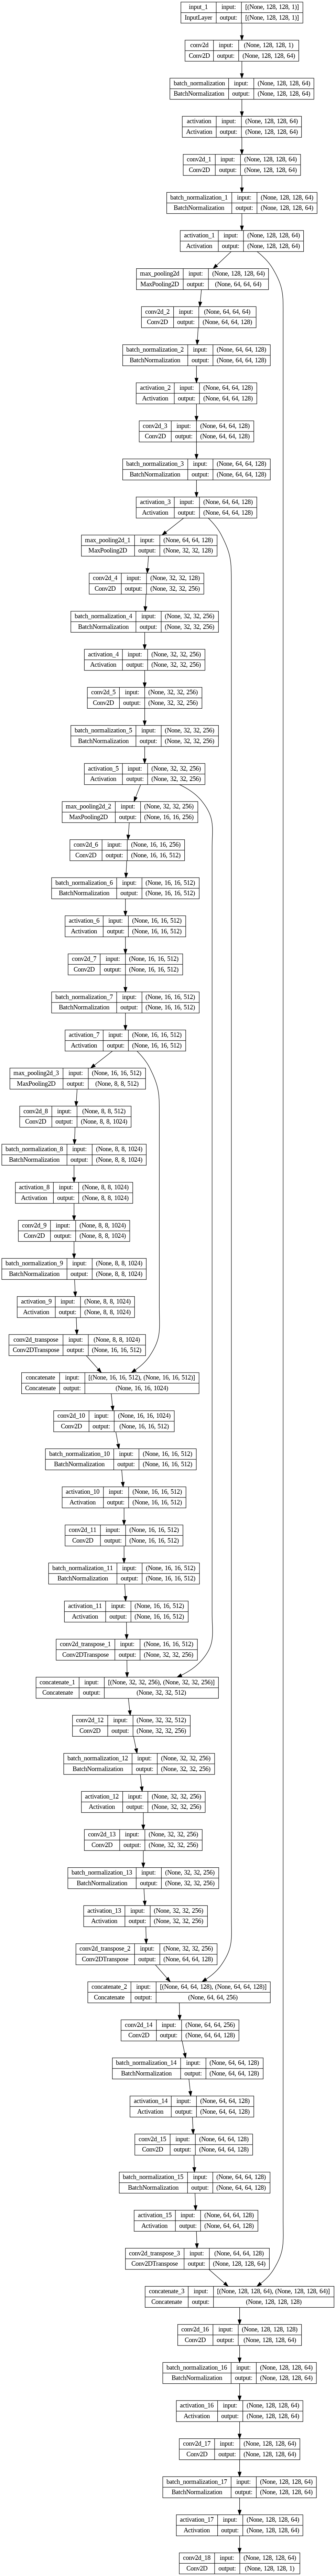

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training:

In [48]:
def create_mask(pred_mask):
  prediction = (pred_mask[0,:,:,0] > 0.5).astype(np.uint8)
  return prediction

The callback defined below is used to observe how the model improves while it is training:

In [49]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(image.shape)
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    print(sample_image[tf.newaxis, ...].shape)
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

(128, 128)
(1, 128, 128)
1/1 [==============================] - 5s 5s/step


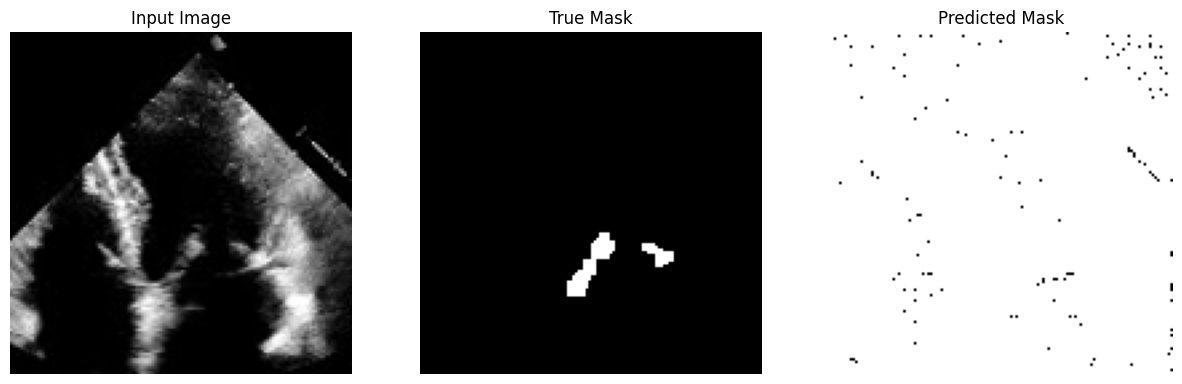

1/1 [==============================] - 0s 19ms/step


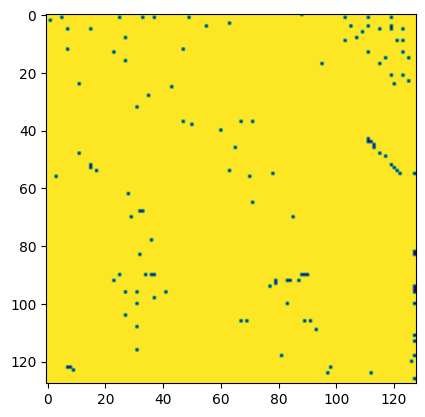

In [50]:
print(sample_image.shape)

show_predictions()

pred_mask = model.predict(sample_image[tf.newaxis, ...])
plt.imshow(create_mask(pred_mask))
plt.show()

In [51]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [52]:
EPOCHS = 30
BATCH_SIZE = 5


VALIDATION_STEPS = 30
STEPS_PER_EPOCH = 200


# TODO: Create a function
#train_images, train_labels = zip(*train_data)
train_images = np.array(images_train).astype(float)
train_labels = np.array(masks_train).astype(int)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(BATCH_SIZE)  # Batch size 5

#test_images, test_labels = zip(*test_data)
test_images = np.array(images_test).astype(float)
test_labels = np.array(masks_test).astype(int)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE)  # Batch size 5

sample = list(train_dataset.take(1))
print(type(sample[0]), len(sample[0]))
print(sample[0][0].shape, sample[0][1].shape)
print(sample[0][0].dtype, sample[0][1].dtype)


sample = list(test_dataset.take(1))
print(type(sample[0]), len(sample[0]))
print(sample[0][0].shape, sample[0][1].shape)
print(sample[0][0].dtype, sample[0][1].dtype)
"""
train_images = np.array(train_images)
train_labels = np.array(train_labels).astype(int)


batches = miniBatch(train_images, train_labels, 32)


print(type(batches[0]), len(batches[0]))
print(batches[0][0].shape, batches[0][1].shape)
"""

<class 'tuple'> 2
(5, 128, 128) (5, 128, 128, 1)
<dtype: 'float64'> <dtype: 'int64'>
<class 'tuple'> 2
(5, 128, 128) (5, 128, 128, 1)
<dtype: 'float64'> <dtype: 'int64'>


'\ntrain_images = np.array(train_images)\ntrain_labels = np.array(train_labels).astype(int)\n\n\nbatches = miniBatch(train_images, train_labels, 32)\n\n\nprint(type(batches[0]), len(batches[0]))\nprint(batches[0][0].shape, batches[0][1].shape)\n'

(1, 128, 128)
1/1 [==============================] - 0s 19ms/step


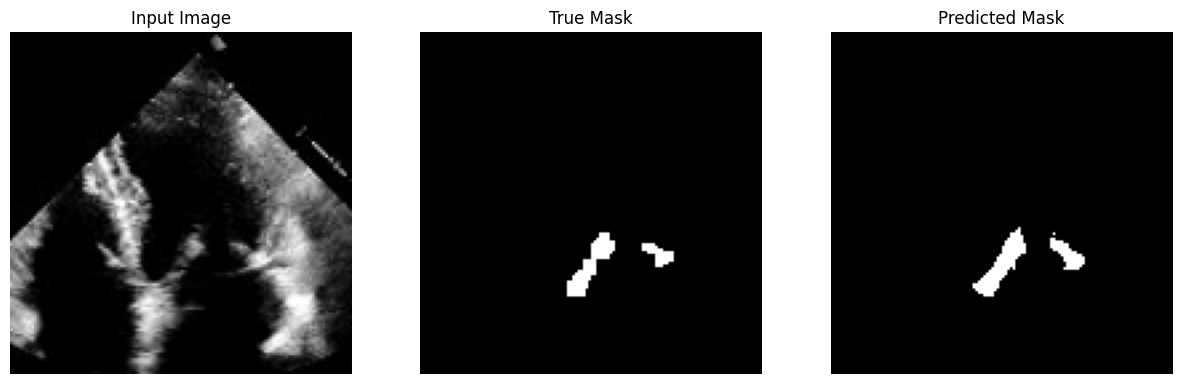


Sample Prediction after epoch 30

32/32 [==============================] - 4s 133ms/step - loss: 0.0970 - accuracy: 0.9965 - val_loss: 0.1520 - val_accuracy: 0.9946


In [53]:
model_history = model.fit(train_dataset, callbacks=[DisplayCallback()], epochs=EPOCHS, validation_data=test_dataset)
#model_history = model.fit(images_train, masks_train, callbacks=[DisplayCallback()], epochs=EPOCHS, validation_data=(images_test, masks_test), batch_size=5)

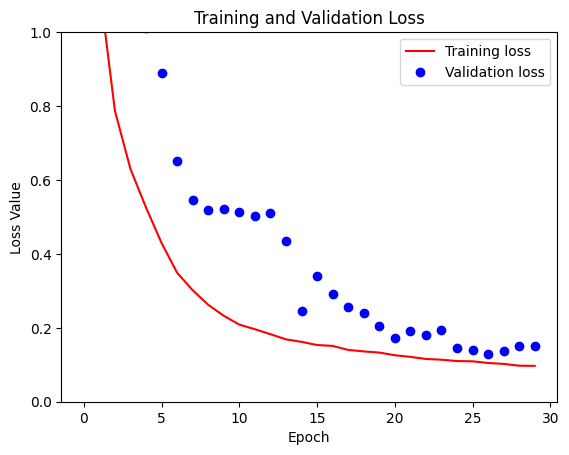

In [54]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [55]:
tf.keras.models.save_model(model, "/content/drive/My Drive/task3/model2.keras")

## Make predictions

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

(5, 128, 128)
1/1 [==============================] - 0s 388ms/step


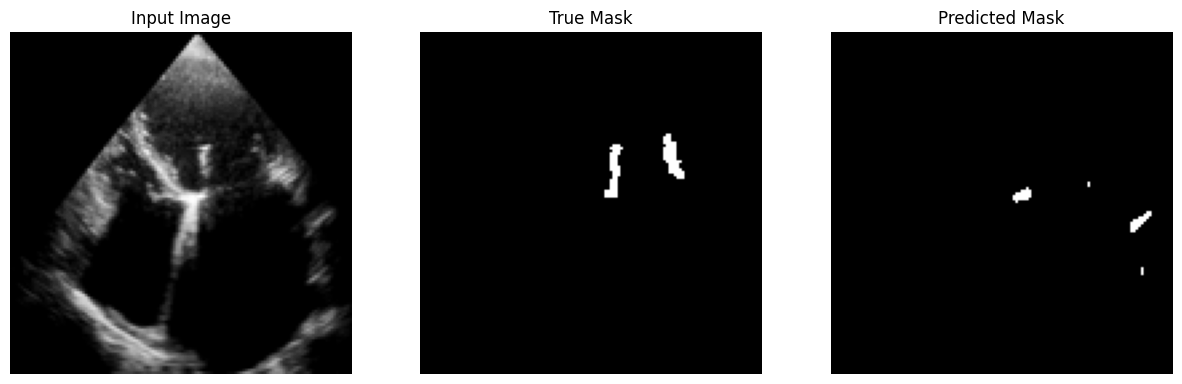

(5, 128, 128)
1/1 [==============================] - 0s 19ms/step


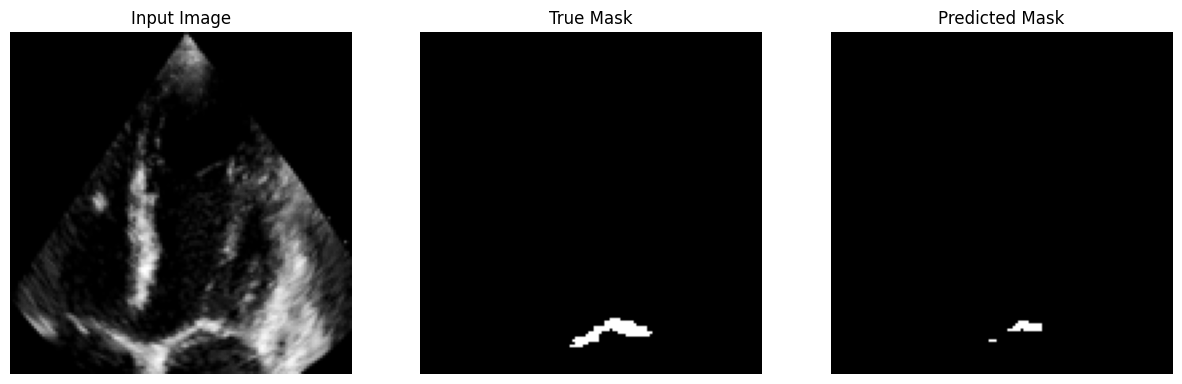

(5, 128, 128)
1/1 [==============================] - 0s 19ms/step


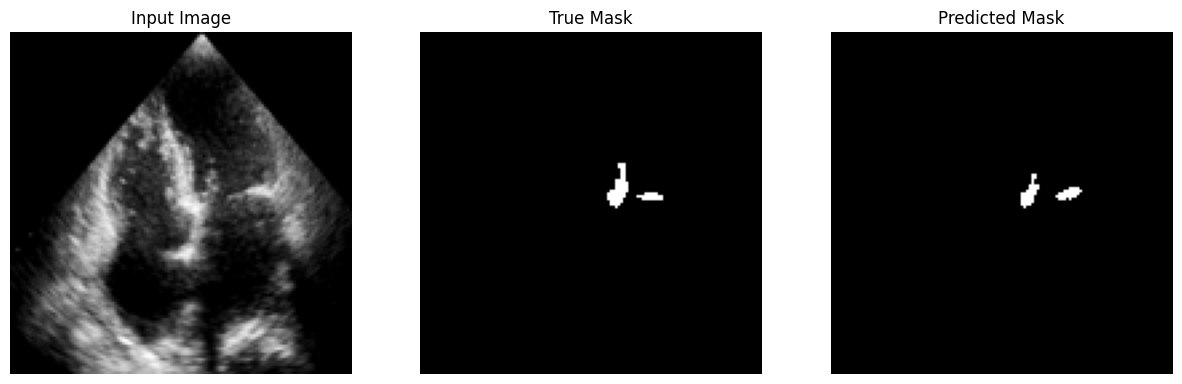

(5, 128, 128)
1/1 [==============================] - 0s 19ms/step


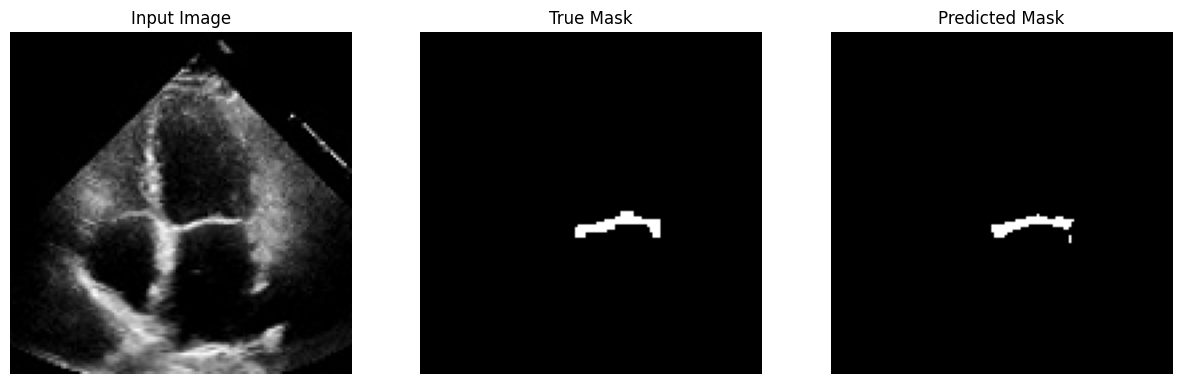

(5, 128, 128)
1/1 [==============================] - 0s 19ms/step


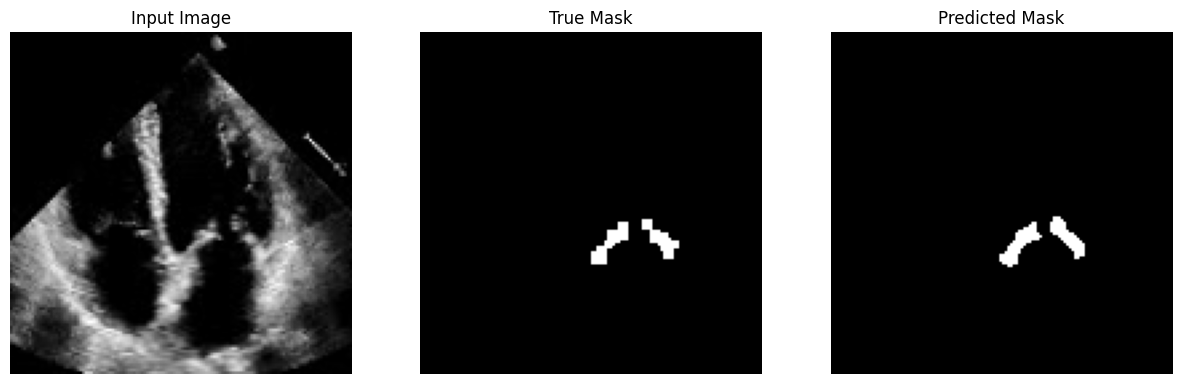

(5, 128, 128)
1/1 [==============================] - 0s 18ms/step


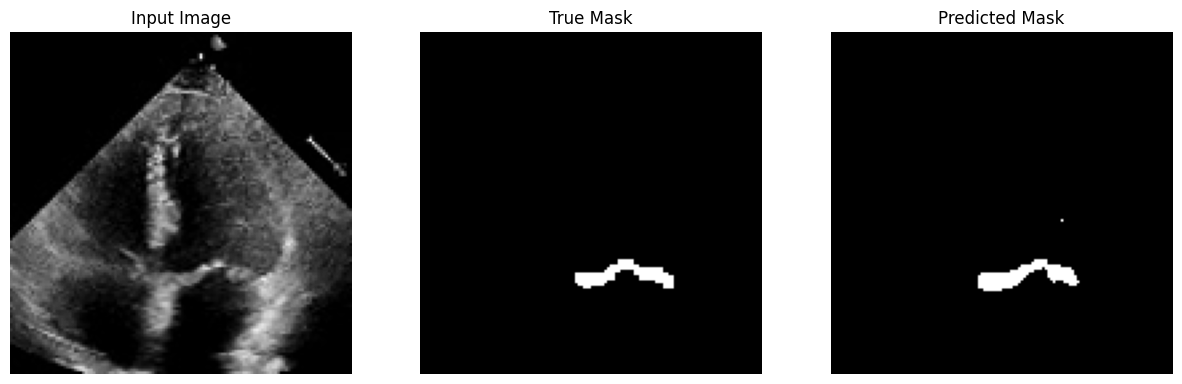

(5, 128, 128)
1/1 [==============================] - 0s 19ms/step


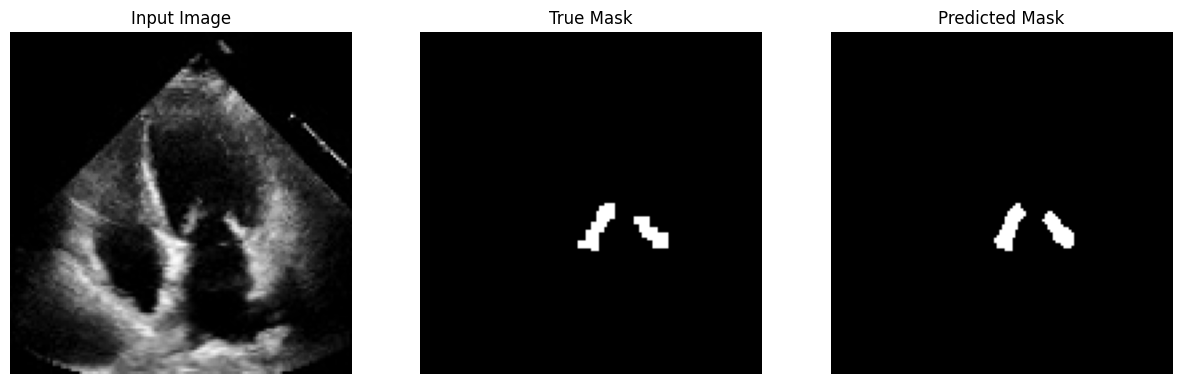

(4, 128, 128)
1/1 [==============================] - 0s 19ms/step


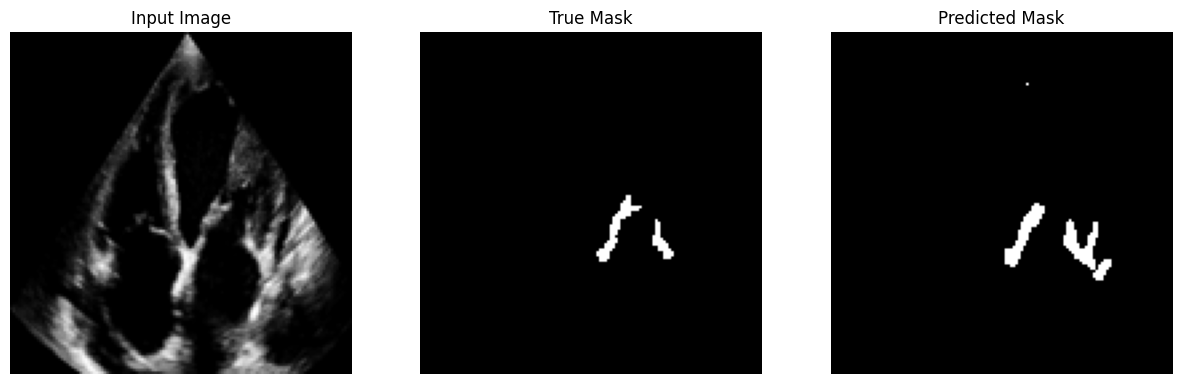

In [56]:
show_predictions(test_dataset, len(test_dataset))

# Helper functions

In [57]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

# Load data, make predictions and save prediction in correct format

In [58]:
# load data
train_data = load_zipped_pickle("/content/drive/My Drive/task3/train.pkl")
test_data = load_zipped_pickle("/content/drive/My Drive/task3/test.pkl")
samples = load_zipped_pickle("/content/drive/My Drive/task3/sample.pkl")

In [59]:
# Load model
loaded_model = tf.keras.models.load_model("/content/drive/My Drive/task3/model.keras")

In [60]:
for sample in samples:
  print(f"name {sample['name']}")
  print(f"shape {sample['prediction'].shape}")

name E9AHVWGBUF
shape (586, 821, 103)
name H7G0BX4HFV
shape (587, 791, 52)
name 8FKMSXTPSJ
shape (583, 777, 69)
name JANFS05F33
shape (582, 851, 61)
name O7WUJ71C15
shape (732, 845, 53)
name 1XHV0Q88M5
shape (583, 809, 84)
name 401JD35E1A
shape (582, 737, 78)
name VODEK84RH4
shape (587, 775, 125)
name ONA22CCCFQ
shape (730, 956, 76)
name 7UXIXUBK2G
shape (587, 781, 104)
name ESY800XYMN
shape (583, 681, 68)
name 571G03ZYDA
shape (587, 713, 90)
name QZA3WA0E2X
shape (587, 612, 78)
name JQX264DTZ0
shape (587, 773, 73)
name TYM0IJW004
shape (707, 855, 39)
name CD4RIAOCHG
shape (731, 1007, 72)
name D271IBSMUW
shape (583, 780, 106)
name 0MVRNDWR1G
shape (583, 670, 63)
name 1QSFD8ORNM
shape (594, 745, 51)
name UB7LFQKZT5
shape (583, 779, 62)


In [61]:
save = None

In [62]:
def get_prediction(height, width, small_image):
  #print(small_image.shape)
  small_image = small_image.reshape((1,) + small_image.shape)
  #print(small_image.shape)
  prediction = model.predict(small_image)
  #print(f'prediction shape {prediction.shape}')
  prediction = prediction[0]
  #print(f'prediction shape {prediction.shape}')
  prediction = Image.fromarray(prediction[:,:,0])
  prediction = prediction.resize((128, 128))
  return np.array(prediction, dtype=bool)

# make prediction for test
predictions = []
for d in test_data:
    prediction = np.array(np.zeros_like(d['video']), dtype=bool)


    video = d['video']
    height = video.shape[1]
    width = video.shape[2]

    # Resize the video so it fits into the model
    small_video = np.array([np.array(Image.fromarray(image).resize((128, 128))) for image in video])

    small_image = small_video[0].reshape((1,) + small_video[0].shape)

    prediction = model.predict(small_video)

    prediction = prediction[:,:,:,0]

    prediction = [np.array(Image.fromarray(mask).resize((width, height)), dtype=bool) for mask in prediction]


    prediction = np.array(prediction, dtype=bool)

    print(f"new predicition shape {prediction.shape} for id {d['name']}")

    """
    for small_image in small_video:
      print(small_image.shape)
      small_image = small_image.reshape((1,) + small_image.shape)
      print(small_image.shape)
      prediction = model.predict(small_image)
      print(f'prediction shape {prediction.shape}')
      prediction = prediction[0]
      print(f'prediction shape {prediction.shape}')
      prediction = Image.fromarray(prediction[:,:,0])

      prediction = prediction.resize((128, 128))
    """

    """
    small_predion = np.array([
        Image.fromarray(
            model.predict(small_image.reshape((1,) + small_image.shape))[:,:,0]
        ).resize((height, width))
        for small_image in small_video], dtype=bool)
      """
    #prediction = np.array([get_prediction(height, width, image) for small_image in small_video])

    #prediction[int(height/2)-50:int(height/2+50), int(width/2)-50:int(width/2+50)] = True

    print(prediction.shape)

    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': prediction
        }
    )


19/19 [==============================] - 16s 375ms/step
new predicition shape (586, 821, 103) for id E9AHVWGBUF
(586, 821, 103)
19/19 [==============================] - 7s 368ms/step
new predicition shape (587, 791, 52) for id H7G0BX4HFV
(587, 791, 52)
19/19 [==============================] - 6s 323ms/step
new predicition shape (583, 777, 69) for id 8FKMSXTPSJ
(583, 777, 69)
19/19 [==============================] - 6s 311ms/step
new predicition shape (582, 851, 61) for id JANFS05F33
(582, 851, 61)
23/23 [==============================] - 11s 486ms/step
new predicition shape (732, 845, 53) for id O7WUJ71C15
(732, 845, 53)
19/19 [==============================] - 2s 125ms/step
new predicition shape (583, 809, 84) for id 1XHV0Q88M5
(583, 809, 84)
19/19 [==============================] - 2s 125ms/step
new predicition shape (582, 737, 78) for id 401JD35E1A
(582, 737, 78)
19/19 [==============================] - 2s 125ms/step
new predicition shape (587, 775, 125) for id VODEK84RH4
(587, 775,

In [63]:
# save in correct format
save_zipped_pickle(predictions, 'my_predictions.pkl')
#save_zipped_pickle(predictions, '/content/drive/My Drive/task3/my_predictions.pkl')